Epoch 1, Loss: 5.7325
Epoch 2, Loss: 3.6926
Epoch 3, Loss: 2.3421
Epoch 4, Loss: 1.7299
Epoch 5, Loss: 1.3564
Epoch 6, Loss: 1.1372
Epoch 7, Loss: 1.0369
Epoch 8, Loss: 0.9789
Epoch 9, Loss: 0.9578
Epoch 10, Loss: 0.9552
Epoch 1, Loss: 7.3048
Epoch 2, Loss: 6.1869
Epoch 3, Loss: 5.2401
Epoch 4, Loss: 4.4924
Epoch 5, Loss: 3.8878
Epoch 6, Loss: 3.3857
Epoch 7, Loss: 2.8953
Epoch 8, Loss: 2.4610
Epoch 9, Loss: 2.1877
Epoch 10, Loss: 1.8668


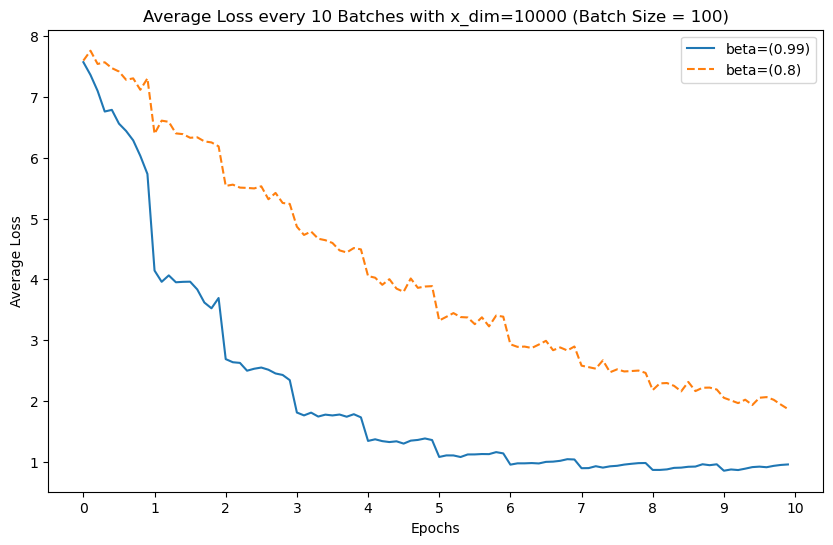

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleAdam:
    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = 0  # First moment
        self.v = 0  # Second moment
        self.t = 0  # Time step

    def update(self, grad):
        self.t += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * grad
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta_1 ** self.t)
        v_hat = self.v / (1 - self.beta_2 ** self.t)
        return -self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

class SimpleRMSprop:
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.v = 0  # Accumulated gradient squared

    def update(self, grad):
        # Update the accumulated squared gradient
        self.v = self.beta * self.v + (1 - self.beta) * (grad ** 2)
        # Compute the RMSprop update
        return -self.lr * grad / (np.sqrt(self.v) + self.epsilon)

# Define a quadratic function acting on one dimension of x
def quadratic_function(x, coeffs, x_dim_idx):
    return coeffs[0] * (x[x_dim_idx] - coeffs[2])**2 + coeffs[1]

# Gradient of the quadratic function
def gradient_quadratic(x, coeffs, x_dim_idx):
    grad = np.zeros_like(x)
    grad[x_dim_idx] = 2 * coeffs[0] * (x[x_dim_idx] - coeffs[2])
    return grad

# Simulate training with input dimension x_dim and each function depending on one dimension of x
def simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.01, beta=0.9, plot_every=10, shuffle=True):
    #x = np.random.uniform(-2, 2, size=x_dim)  # Initialize x for all dimensions
    x = 3 * np.ones(x_dim)
    optimizer = SimpleRMSprop(lr=lr, beta=beta)
    
    # Define quadratic functions with a mix of easy and hard examples
    coeffs_list = np.random.uniform(0.5, 1.0, size=(num_functions, 3))  # Coefficients for random functions
    coeffs_list[:, 2] = np.random.uniform(-1, 1, size=num_functions)  # Minima near zero
    
    # Assign each function to act on a random dimension of x
    x_dim_indices = np.random.randint(0, x_dim, size=num_functions)
    
    avg_loss_history = []
    for epoch in range(num_epochs):
        # Shuffle the coefficients and indices if shuffle=True
        if shuffle:
            perm = np.random.permutation(num_functions)
            coeffs_list = coeffs_list[perm]
            x_dim_indices = x_dim_indices[perm]
        
        accumulated_loss = 0
        for i in range(0, num_functions, batch_size):
            batch_coeffs = coeffs_list[i:i+batch_size]
            batch_dim_indices = x_dim_indices[i:i+batch_size]
            
            # Compute loss for the current batch
            batch_loss = 0
            batch_grad = np.zeros_like(x)
            for coeffs, x_dim_idx in zip(batch_coeffs, batch_dim_indices):
                batch_loss += quadratic_function(x, coeffs, x_dim_idx)
                batch_grad += gradient_quadratic(x, coeffs, x_dim_idx)
            
            # Average loss and gradient across the batch
            batch_loss /= batch_size
            batch_grad /= batch_size
            
            accumulated_loss += batch_loss
            
            # Update x using the Adam optimizer based on batch gradient
            x += optimizer.update(batch_grad)
            
            # After every 'plot_every' batches, record the average loss and reset accumulated loss
            if (i // batch_size + 1) % plot_every == 0:
                avg_loss_history.append(accumulated_loss / plot_every)
                accumulated_loss = 0
        
        # Record the loss at the end of each epoch
        print(f'Epoch {epoch+1}, Loss: {avg_loss_history[-1]:.4f}')
    
    return avg_loss_history

# Set the parameters for the simulation
num_epochs = 10
batch_size = 100
num_functions = 10000  # Total number of quadratic functions
x_dim = 10000  # Dimensionality of input vector x
plot_every = 10  # Plot average loss every 10 batches
# Simulate training with two different beta_2 values
beta1 = 0.99
beta2 = 0.8
loss_history_betas_1 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, beta=beta1, plot_every=plot_every, shuffle=True)
loss_history_betas_2 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, beta =beta2, plot_every=plot_every, shuffle=True)

# Plot the average loss history every 'plot_every' batches
t = np.arange(len(loss_history_betas_1))
t = t / (num_functions / batch_size / plot_every)
t_ticks = np.arange(0, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(t, loss_history_betas_1, label=f'beta=({beta1})', linestyle='-')
plt.plot(t, loss_history_betas_2, label=f'beta=({beta2})', linestyle='--')
plt.gca().set_xticks(t_ticks)
plt.xlabel(f'Epochs')
plt.ylabel('Average Loss')
plt.title(f'Average Loss every {plot_every} Batches with x_dim={x_dim} (Batch Size = {batch_size})')
plt.legend()
plt.show()